# Example on how to use MEG for a qutrit state tracking

In [1]:
# preample 
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm,sqrtm,logm,eig

In [2]:
def generate_random_state(dim):
    """
    a function to generate a random state using the Haar measure, returns the density matrix
    
    dim: dimension of the state
    """
    # generate a random complex matrix of dimension dim-by-dim
    A = np.random.rand(dim,dim) + 1j* np.random.rand(dim,dim)
    
    # multiply be hermitian conjugate
    rho = A@A.conj().T
    
    # normalize
    rho = rho/np.trace(rho)
    
    # done!
    return rho  

In [3]:
def generate_MUB_3():
    """
    a function to generate all the MUB's for d=3
    """
    
    # define the coefficients matrix [replace with correct coefficients for other dimensions if MUB exists]
    M = [ 
        [np.array([[1,0,0]]).T,  np.array([[0,1,0]]).T, np.array([[0,0,1]]).T],
        [np.array([[1,1,1]]).T/np.sqrt(3), np.array([[1,np.exp(2*np.pi*1j/3),np.exp(-2*np.pi*1j/3)]]).T/np.sqrt(3), np.array([[1,np.exp(-2*np.pi*1j/3),np.exp(2*np.pi*1j/3)]]).T/np.sqrt(3)],
        [np.array([[1,np.exp(2*np.pi*1j/3),np.exp(2*np.pi*1j/3)]]).T/np.sqrt(3),   np.array([[1,np.exp(-2*np.pi*1j/3),1]]).T/np.sqrt(3), np.array([[1,1,np.exp(-2*np.pi*1j/3)]]).T/np.sqrt(3)],
        [np.array([[1,np.exp(-2*np.pi*1j/3),np.exp(-2*np.pi*1j/3)]]).T/np.sqrt(3), np.array([[1,1,np.exp(2*np.pi*1j/3)]]).T/np.sqrt(3),  np.array([[1,np.exp(2*np.pi*1j/3),1]]).T/np.sqrt(3)]
        ]

    return [[x@x.conj().T for x in m] for m in M]

In [4]:
def generate_Generalized_Pauli(dim):
    """
    a function to calculate a list of all generalized Pauli's according to https://arxiv.org/abs/quant-ph/0301152 [has typo in definition of w] and https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.47.838
    
    dim: dimension of the state
    """
    I   = np.eye(dim) 
    ket = lambda i: I[:,i:i+1]
    bra = lambda i: I[i:i+1, :]
    
    # there are 3 types of operators, u_jk, v_jk, and w_l, for 0<j<k<d, 0<l<d, prepare all of these lists and concatenate them
    u = sum( [ [ket(j)@bra(k) + ket(k)@bra(j) for j in range(dim) if j<k] for k in range(dim)], [] )
    v = sum( [ [-1j*(ket(j)@bra(k) - ket(k)@bra(j)) for j in range(dim) if j<k] for k in range(dim)], [] )
    w = [ (np.sqrt(2)/np.sqrt(l*(l+1))) * (sum( [ket(j-1)@bra(j-1) for j in range(1,l+1)], 0)- l*ket(l)@bra(l)) for l in range(1,dim)]
    return u+v+w

In [5]:
def generate_Generalized_Pauli_Projectors(dim):
    """
    a function to calculate a list of all the projectors of the generalized Pauli's
    
    dim: dimension of the state
    """
    X = generate_Generalized_Pauli(dim) 
    projectors = []
    # loop over each operators
    for x in X:
        Q = eig(x)[1] # eigenvector matrix
        projectors.append( [Q[:, idx:idx+1]@Q[:, idx:idx+1].conj().T for idx in range(dim)] )
    return projectors

In [6]:
def trace_norm(rho):
    """
    a function to calculate the trace norm of a density matrix
    
    rho: the state we want to calculate its trace norm
    """
    
    return np.real(np.trace( sqrtm( rho @ rho.conj().T )))

def density_fidelity(rho,sigma):
    """
    a function to calculate the fidelity between two states represented by their density matrix
    
    rho   : the first state
    sigma : the other state
    """
    return trace_norm( sqrtm(rho) @ sqrtm(sigma) )**2;

In [7]:
def MEG_update(rho_t, Gt, X_t, y_t, eta_t):
    """
    state estimate update for MEG using multiple measurements per iteration
    
    rho_t   : the old estimate of the state
    G_t     : the old Gt vlaue
    X_t     : a list of measurement operators 
    y_t     : a list of the measurement outcomes
    eta_t   : the learning rate 
    """      
    # Calculate the gradient of the loss function
    grad_loss = sum( [2 * (np.trace(rho_t @ X) - y) * X for (X,y) in zip(X_t, y_t)] )
    
    # update
    G_new = Gt - eta_t*grad_loss    
    
    # exponentiate
    rho_new = expm(G_new)
    
    # normalize
    rho_new = rho_new / np.trace(rho_new)
    
    # done!
    return rho_new, G_new

In [8]:
# parameters for the algorithm
dim        = 3                                                                     # dimension of the density matrix
est_0      = 0.999*np.ones((dim,dim))/dim + 0.001*np.eye(dim)/dim                  # initial estimate

nIter      = 1000                                                                  # number of iterations
nStates    = 50                                                                    # number of states
eta        = 0.5                                                                   # learning rate

# parameters for time-evolution
axis    = np.random.rand(dim**2-1)                                                 # define a random rotation axis
axis    = axis/np.linalg.norm(axis, 2)                                             # normalize the rotation axis
SIGMA_r = sum([a*sigma for a, sigma in zip(axis,generate_Generalized_Pauli(dim))]) # define the random Hermitian matrix
theta = 2*np.pi                                                                    # maximum rotation angle

In [9]:
X_MUB      = generate_MUB_3()                                                      # generate MUB's
X_GP       = generate_Generalized_Pauli_Projectors(dim)                            # generate generalized Pauli's projectors

In [10]:
Infidelity_1   = np.zeros((nStates, nIter))        # array to store the infidelities for the constant learning rate and MUB
Infidelity_2   = np.zeros((nStates, nIter))        # array to store the infidelities for the variable learning rate and MUB

Infidelity_3   = np.zeros((nStates, nIter))        # array to store the infidelities for the constant learning rate and GP
Infidelity_4   = np.zeros((nStates, nIter))        # array to store the infidelities for the variable learning rate and GP


for idx_state in range(nStates):
    # generate a density matrix
    true_state = generate_random_state(dim)
  
    # add a time-varying rotation
    true_state_time = [expm(-1j * 0.5 * theta * SIGMA_r * t/nIter) @ true_state @ expm(-1j * 0.5 * theta * SIGMA_r * t/nIter).conj().T for t in range(nIter)]
    
    
    # Initilaizations for MEG with variable learning rate and MUB
    sigma_estimate_1 = est_0                             # initial state estimate 
    St_1             = logm(sigma_estimate_1)            # initial Gt value (needed for the update rule)
 
    # Initilaizations for MEG with constant learning rate and MUB
    sigma_estimate_2 = est_0                             # initial state estimate
    St_2             = logm(sigma_estimate_2)            # initial Gt value (needed for the update rule)
    
    #  Initilaizations for MEG with variable learning rate and GP
    sigma_estimate_3 = est_0                             # initial state estimate 
    St_3             = logm(sigma_estimate_3)            # initial Gt value (needed for the update rule)
 
    #  Initilaizations for MEG with constant learning rate and GP
    sigma_estimate_4 = est_0                             # initial state estimate
    St_4             = logm(sigma_estimate_4)            # initial Gt value (needed for the update rule)
    
    # do the estimation iterations using MUB measurements
    for idx_iter in range(nIter):

        # 1) randomly pick a measurement basis
        idx_basis = np.random.randint(0, len(X_MUB)) 
        
        # 2) do the measurement [simulate as a multinmoial random variable] 
        nShots = 10**3
        prob   = [np.real( np.trace(x @ true_state_time[idx_iter]) ) for x in X_MUB[idx_basis]]
        y_t    = np.random.multinomial(nShots, prob)/nShots # probability   

        # 3) update the estimate using MEG with variable learning rate
        sigma_estimate_1, St_1 = MEG_update(sigma_estimate_1, St_1, X_MUB[idx_basis], y_t, eta/np.sqrt(idx_iter+1) )
        
        # 4) update the estimate using MEG with constant learning rate
        sigma_estimate_2, St_2 = MEG_update(sigma_estimate_2, St_2, X_MUB[idx_basis], y_t, eta )

        # 5) calculate the fidelity with the true state for performance comparison [for simulations if we know true state]
        Infidelity_1[idx_state, idx_iter] =  1 - density_fidelity(sigma_estimate_1, true_state_time[idx_iter])   
        Infidelity_2[idx_state, idx_iter] =  1 - density_fidelity(sigma_estimate_2, true_state_time[idx_iter])  
        
        
    # do the estimation iterations using generalized Pauli measurements
    for idx_iter in range(nIter):

        # 1) randomly pick a measurement basis
        idx_basis = np.random.randint(0, len(X_GP)) 
        
        # 2) do the measurement [simulate as a multinmoial random variable] 
        nShots = 10**3
        prob   = [np.real( np.trace(x @ true_state_time[idx_iter]) ) for x in X_GP[idx_basis]]
        y_t    = np.random.multinomial(nShots, prob)/nShots # probability   

        # 3) update the estimate using MEG with variable learning rate
        sigma_estimate_3, St_3 = MEG_update(sigma_estimate_3, St_3, X_GP[idx_basis], y_t, eta/np.sqrt(idx_iter+1) )
        
        # 4) update the estimate using MEG with constant learning rate
        sigma_estimate_4, St_4 = MEG_update(sigma_estimate_4, St_4, X_GP[idx_basis], y_t, eta )

        # 5) calculate the fidelity with the true state for performance comparison [for simulations if we know true state]
        Infidelity_3[idx_state, idx_iter] =  1 - density_fidelity(sigma_estimate_3, true_state_time[idx_iter])   
        Infidelity_4[idx_state, idx_iter] =  1 - density_fidelity(sigma_estimate_4, true_state_time[idx_iter])  
    print("Estimating state %d of %d"%(idx_state+1,nStates), end='\r')

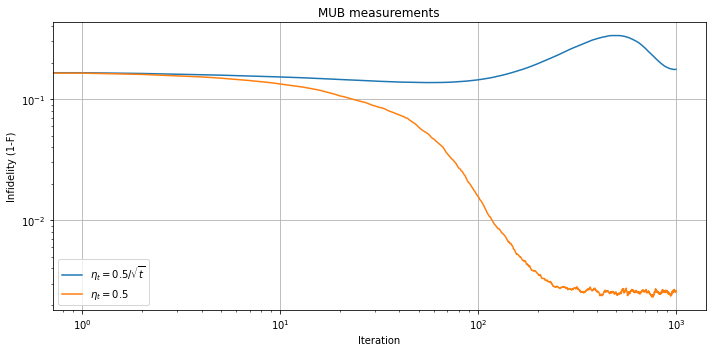

In [11]:
plt.figure(figsize = [10,5])
plt.title("MUB measurements")
plt.loglog(np.mean(Infidelity_1, 0),     label='$\eta_t=0.5/\sqrt{t}$')
plt.loglog(np.mean(Infidelity_2, 0),     label='$\eta_t=0.5$')
plt.xlabel('Iteration')
plt.ylabel('Infidelity (1-F)')
plt.grid()
plt.legend()
plt.tight_layout()

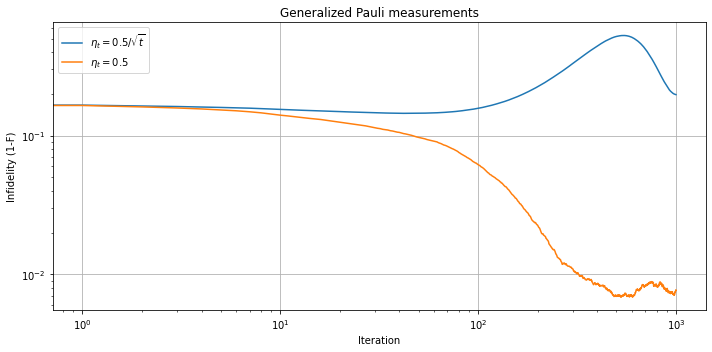

In [12]:
plt.figure(figsize = [10,5])
plt.title("Generalized Pauli measurements")
plt.loglog(np.mean(Infidelity_3, 0),     label='$\eta_t=0.5/\sqrt{t}$')
plt.loglog(np.mean(Infidelity_4, 0),     label='$\eta_t=0.5$')
plt.xlabel('Iteration')
plt.ylabel('Infidelity (1-F)')
plt.grid()
plt.legend()
plt.tight_layout()